In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
img_id = "CA184632V0341"

<h4>Load Image</h4>

In [33]:
import src.load.load_image as ld

#path_data_fld = "C:/Users/Felix/Documents/GitHub/Antarctic_TMA/data"
path_data_fld = "/data_1/ATM/data_1/aerial/TMA/downloaded"

# load image to geo-reference
image = ld.load_image(path_data_fld + f"/{img_id}.tif")

print(image.shape)

(9522, 10140)


<h4>Extract geo-referencing data</h4>

In [34]:
import src.base.connect_to_database as ctd

sql_string = f"SELECT * FROM images WHERE image_id='{img_id}'"
conn = ctd.establish_connection()
data = ctd.execute_sql(sql_string, conn)

azimuth = data.iloc[0]['azimuth']
month = data.iloc[0]['date_month']

azimuth = 360 - azimuth + 90

print("Azimuth:", azimuth)
print("Month:", month)

sql_string_approx = f"SELECT ST_AsText(footprint_approx) AS footprint_approx FROM images_extracted WHERE image_id='{img_id}'"
data_approx = ctd.execute_sql(sql_string_approx, conn)
footprint_approx = data_approx.iloc[0]['footprint_approx']

print("Approx footprint:",footprint_approx)

Azimuth: 338.8565
Month: 12
Approx footprint: POLYGON((-1919240.9617884748 746904.483180359,-1922326.856819641 738925.2417884748,-1930306.0982115252 742011.1368196411,-1927220.203180359 749990.3782115253,-1919240.9617884748 746904.483180359))


<h4>Create Mask</h4>

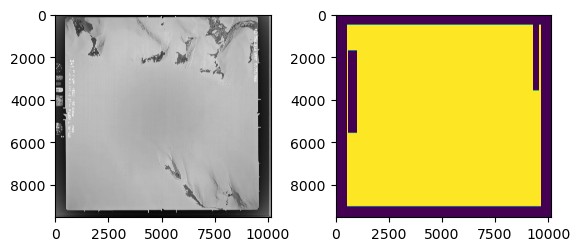

In [35]:
import src.base.create_mask as cm

import src.display.display_images as di

sql_string_fid_marks = f"SELECT * FROM images_fid_points WHERE image_id='{img_id}'"
data_fid_marks = ctd.execute_sql(sql_string_fid_marks, conn)

sql_string_extracted = f"SELECT * FROM images_extracted WHERE image_id='{img_id}'"
data_extracted = ctd.execute_sql(sql_string_extracted, conn)

# Get the fid marks for the specific image_id
fid_marks_row = data_fid_marks.loc[data_fid_marks['image_id'] == img_id].squeeze()

# Create fid mark dict using dictionary comprehension
fid_dict = {i: (fid_marks_row[f'fid_mark_{i}_x'], fid_marks_row[f'fid_mark_{i}_y']) for i in range(1, 5)}

# get the text boxes of the image
text_string = data_extracted.loc[data_extracted['image_id'] == img_id]['text_bbox'].iloc[0]

# create text-boxes list
text_boxes = [list(group) for group in eval(text_string.replace(";", ","))]

# load the mask
mask = cm.create_mask(image, fid_dict, text_boxes)

di.display_images([image, mask])

<h4>Geo-reference the image</h4>

In [36]:
import src.georef.georef_sat as gs

georefSat = gs.GeorefSatellite(min_tps_final=25,
                               enhance_image=False, locate_image=True, tweak_image=True,filter_outliers=True)

transform, residuals, tps, conf = georefSat.georeference(image, footprint_approx, mask, azimuth, month)

if transform is not None:
    print("Image successfully geo-referenced")

Geo-reference image by satellite
Adjusted image resolution with zoom-factor (0.0884, 0.0859)
Adjusted image resolution with zoom-factor (0.0884, 0.0859)
Locate image position
  Check tile 1 (Coords: [-7386, -7380], Order 1)
  0 points were found in this tile.
  Check tile 2 (Coords: [-7386, 0], Order 1)
  0 points were found in this tile.
  Check tile 3 (Coords: [-7386, 7380], Order 1)
  95 points were found in this tile.
  Check tile 4 (Coords: [0, -7380], Order 1)
  0 points were found in this tile.
  Check tile 5 (Coords: [0, 7380], Order 1)
  165 points were found in this tile.
  Check tile 6 (Coords: [7386, -7380], Order 1)
  0 points were found in this tile.
  Check tile 7 (Coords: [7386, 0], Order 1)
  0 points were found in this tile.
  Check tile 8 (Coords: [7386, 7380], Order 1)
  0 points were found in this tile.
  Check tile 9 (Coords: [-14772, -14760], Order 2)
  4 points were found in this tile.
  Check tile 10 (Coords: [-14772, -7380], Order 2)
  13 points were found in 

<h4>Verify the image geometry</h4>

In [37]:
import src.georef.snippets.verify_image_geometry as vig
valid_geometry, reason = vig.verify_image_geometry(image, transform)

if valid_geometry:
    print("Valid geometry:", valid_geometry)
else:
    print("Invalid because of:", reason)

Valid geometry: True


<h4>Save the data </h4>

In [38]:
import numpy as np
import pandas as pd

import src.georef.snippets.apply_transform as af
import src.georef.snippets.convert_image_to_footprint as citf

import src.export.export_geometry as eg

# define the output folder
output_fld = "/data_1/ATM/data_1/georef"
path_shp_file = f"{output_fld}/sat.shp"

# apply the transform and save geo-referenced tiff
af.apply_transform(image, transform, f"{output_fld}/sat/{img_id}.tif")

# save transform and points
np.savetxt(f"{output_fld}/sat/{img_id}_transform.txt", transform)
np.savetxt(f"{output_fld}/sat/{img_id}_points.txt", tps)

# create a footprint for this image
footprint = citf.convert_image_to_footprint(image, transform)

# define attributes
attributes = {
    'image_id': img_id,
    'azimuth': azimuth,
    'month': month,
    'num_tps': tps.shape[0],
    'avg_conf': round(np.mean(conf), 3),
    'avg_resi': round(np.mean(residuals), 3),
}

attributes = pd.DataFrame.from_dict(attributes, orient='index').T
print(attributes)

# save footprint to shp file
eg.export_geometry(footprint, path_shp_file,
                   attributes=attributes, key_field="image_id",
                   overwrite_file=False,
                   overwrite_entry=True, attach=True)


        image_id   azimuth month num_tps avg_conf avg_resi
0  CA184632V0341  338.8565    12     107     0.41  124.582
                                            geometry       image_id   azimuth  \
0  POLYGON ((-1930626.799 755375.804, -1933016.67...  CA184632V0341  338.8565   

   month  num_tps  avg_conf  avg_resi  
0     12      107      0.41   124.582  
